# Clustering with fuzzy c-means, creating your own membership functions

## Assignment 2

In this assignment you are going to find about how the Fuzzy C-Means algorithm works, you are going to implement it and use it for the creation of your Gaussian membership functions. 
- First, you can go over a summary of the theory behind Fuzzy C-Means.
- Second, you can fill in your code for the assignment in this notebook. The number of points is indicated per assignment. There are a few questions that are theoretical, enter them in the markdown cells with 'YOUR ANSWER HERE'.

## Theory

Within Fuzzy C-Means you have to determine the required number of clusters and then the algorithm tries to put each of the data points to one of the clusters. Fuzzy C-Means is different from the (probably known to you) K-Means algorithm, in that it does not decide the absolute membership of a data point to a given cluster. Instead, it calculates a point's degree of membership to that cluster.

How does the algorithm work? First you initialize the cluster centers. This can be done randomly, but also in more smarter ways, such as starting with two datapoints from your dataset. In each iteration of the FCM algorithm, the objective function J is minimised:

<img src="https://i.imgur.com/VSOs2Gq.png" width="600"></img>

We minimise the objective function by reestimating the cluster centres and recalculating the membership degrees until the algorithm has converged or the maximum number of iterations has been reached. Convergence means that both the membership degrees and cluster centers remain the same for two iterations, or the coefficients' change between two iterations is no more than a predefined sensitivity threshold.

<img src="https://i.imgur.com/SWW054Y.png" width="500"></img>

Here $m > 1$ is the fuzziness coefficient, that measures the tolerance of the clustering. This value determines how much the clusters can overlap with one another. The higher the value of $m$, the larger the overlap between clusters. 

The algorithm in short:
 - Initialize centers, randomly or in a smarter way
 - Repeat until convergence
     1. Calculate membership degrees
     2. Recalculate centers

## Practice

## 1. Inspecting the data (15 points total)

Make sure you have the required libraries installed. They are all gathered in the first code cell. The most uncommon library is skfuzzy, install it with 'pip install scikit-fuzzy' or 'conda install scikit-fuzzy'. Documentation for scikit-fuzzy can be found here: http://pythonhosted.org/scikit-fuzzy/.

To start with, we are looking at two datasets you are going to work with in this assignment. Run the code below to find out what the data looks like.

### Question 1.1 (10 points)

Specify a suitable universe of discourse for both datasets, for both input variables:
> Dataset 1, input 1: [0.0, 26.6]

> Dataset 1, input 2: [0.0, 85.4]

> Dataset 2, input 1: [0.01, 19.99]

> Dataset 2, input 2: [0.0, 1.0]

### Question 1.2 (5 points)

We are going to use these datasets for clustering. Inspect the distribution of points in the plot, indicate if you think the dataset consists of clusters of datapoints (refer to the image) and if so, how many:
> Dataset 1: Yes, either three or four clusters.

> Dataset 2: No 

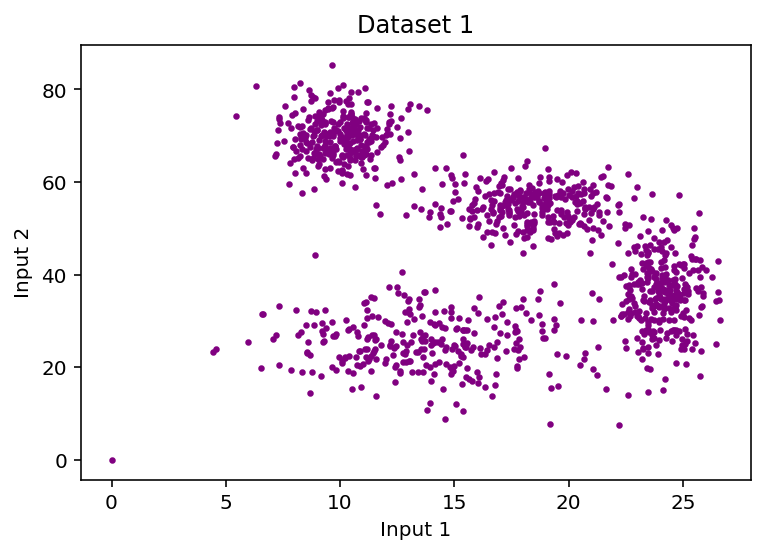

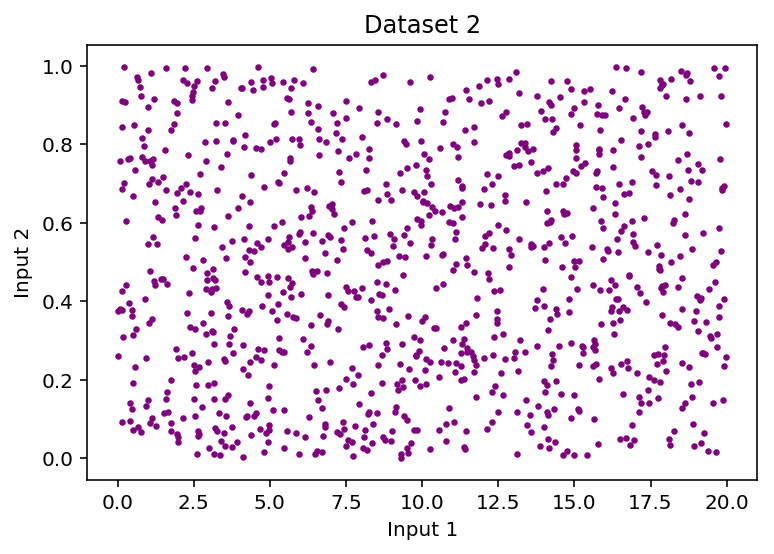

In [1]:
import pickle
import random
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from time import time
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def plot_data(xpts, ypts, title):
    """Create simple scatter plot."""
    plt.scatter(xpts, ypts, s=5, color='purple')
    plt.xlabel("Input 1")
    plt.ylabel("Input 2")
    plt.title(title)
    plt.show()

xpts1, ypts1 = pickle.load(open("./res/dataset_1.pickle", 'rb'))
plot_data(xpts1, ypts1, "Dataset 1")

xpts2, ypts2 = pickle.load(open("./res/dataset_2.pickle", 'rb'))
plot_data(xpts2, ypts2, "Dataset 2")

In [2]:
def plot_clusters(x, y, cntr, u):
    """Plot clusters by assigning datapoints to the cluster
    for which the datapoint has the highest membership degree."""
    colors = ['magenta', 'purple', 'darkblue', 'lightblue', 'yellow', 'red', 'blue']

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(len(cntr)):
        plt.scatter(x[cluster_membership == j],
                    y[cluster_membership == j], 
                    color=colors[j], s=5)

        # Mark the center of each fuzzy cluster
        for pt in cntr:
            plt.plot(pt[0], pt[1], 'rs')

## 2. Fuzzy C-Means (55 points total)

### Question 2.1 (35 points for implementation, 10 points for clear commenting)

Implement the Fuzzy C-Means algorithm <b>yourself</b>, using the theory shown at the start of the assignment. Make sure that you clearly comment your code, to let the reader understand your program flow.
1. Implement ```initialize_centers()```. Initialize centers randomly or in a smarter way of your choosing.
2. Implement ```c_means()```. To apply the formulas shown above, it is useful to represent datapoints as vectors, instead of saving x and y coordinates separately. This has been done for you already (see variable datapoints). 
3. __Hint:__ You can calculate the Eucledian distance between a datapoint and a center using ```np.linalg.norm()```.
4. The functions given below are only there to get you started, you can add and remove parameters for functions if needed.
5. Let the algorithm run for the maximum number of iterations, or until the centers and membership degrees have not changed for two iterations.
6. Outputs ```centers``` and ```u``` should have the following layout, and should be numpy arrays:

In [3]:
n_centers = 4
m = 2.5
max_iter = 50

# Centers are initialised using random datapoint locations
def initialize_centers(xpts, ypts, n_centers):
    """Initialize fuzzy c-means clusters."""
    
    # Predetermine indices used to locate random datapoints
    indices = [random.randint(0, len(xpts) - 1) for i in range(n_centers)]
    
    # Collect datapoints at random index locations
    init =    [([xpts[i], ypts[i]]) for i in indices]
    return np.array(init).astype(int)

In [4]:
# Calculate membership of x datapoint for c center
def membership(x, c, centers, m):
    """Calculates membership for datapoint x for center c."""
    
    # If x equals zero, it's initialised with a miniscule value
    # to prevent division by zero
    x[x == 0] = 2e-26
    
    # Converted membership formula as given
    return 1 / (sum([np.linalg.norm(x - c) / np.linalg.norm(x - k) for k in centers]) ** 2 / (m-1))

................ 16 iterations


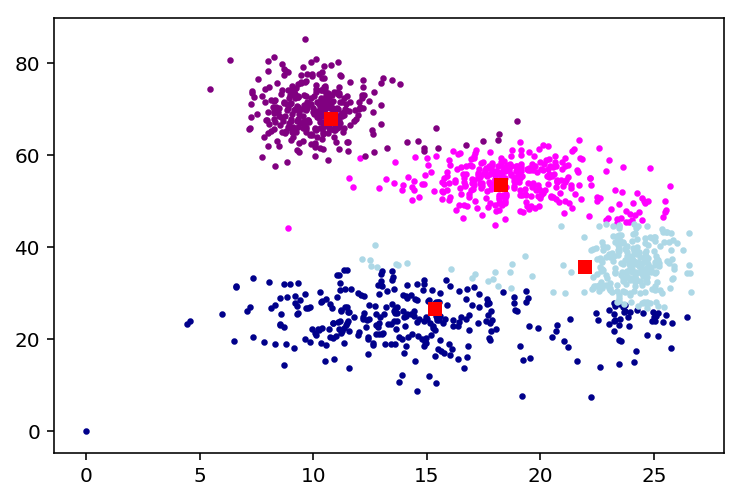

In [5]:
# Iteratively calculates centers of clusters
def c_means(xpts, ypts, n_centers, m, max_iter, init):
    """Fuzzy C-Means clustering algorithm."""
    
    # Zips datapoints
    datapoints = np.matrix(list(zip(xpts, ypts)))
    
    # Parameters to manage iterations
    converged_after_iter = 2
    cur_iter = 0
    
    # Changed centers to float type to make sure
    # y position is shown in graph using y range
    # (0, 1)
    centers = init.astype(float)
    # Requires threshold as centers won't be ex-
    # actly equal
    converged_threshold = 0.01
    
    # Create empty matrix of centers x datapoints
    u = np.empty(shape = (n_centers, len(xpts)))
    
    # Main loop converges when max iterations is reached or
    # two iterations go by without improvement
    while (cur_iter < max_iter and converged_after_iter != 0):
        print('.', end='', flush=True)
        
        cur_iter += 1
        old_centers = centers.copy()
        
        for j, c in enumerate(centers):
            for i, x in enumerate(datapoints):
                u[j][i] = membership(x, c, centers, m)
            centers[j] = (sum(u[j] * datapoints) / sum(u[j]))
            
        # If centers haven't improved
        if ((old_centers - centers < converged_threshold).all()):
            converged_after_iter -= 1
            
    print("", cur_iter, "iterations")
            
    return centers, u

# Check to see if your functions give sensible output
init = initialize_centers(xpts1, ypts1, n_centers)
centers, u = c_means(xpts1, ypts1, n_centers, m, max_iter, init)
plot_clusters(xpts1, ypts1, centers, u)
plt.show()

### Question 2.2 (10 points)

Now compare your clusters to the clusters of scikit fuzzy, by plotting both clusters using the ```plot_clusters()``` function. This can be done by running the code below, or adapting it according to your own data representation. <b>Note: if your implementation is complete (not necessarily correct) and you did not change parameters in function headers, this should run without errors.</b>

If your clusters are the same as the scikit fuzzy clusters, or if you did not manage to implement Fuzzy C-Means: do you think the clusters are optimal? Explain why!

If your clusters differ from the scikit fuzzy clusters: which ones look better? Explain why!

> The scikit looks a little better, the centers are actually located at the most dense locations of each cluster.

In [6]:
error = 0.0005  # This variable is needed in the next cell
                # although it was defined in a later cell.

.................. 18 iterations
................ 16 iterations
Dataset 1


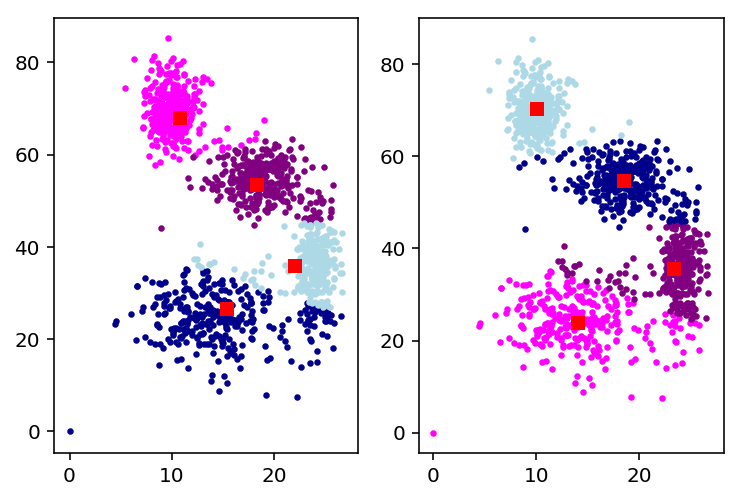

Dataset 2


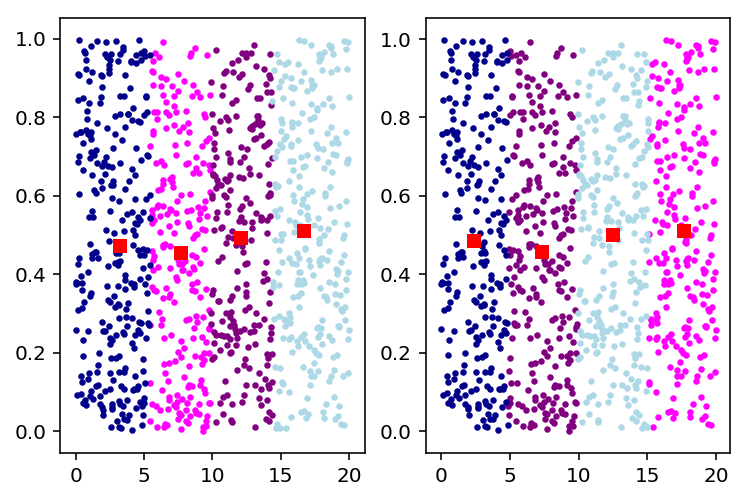

In [7]:
# Your own fuzzy c-means
init1 = initialize_centers(xpts1, ypts1, n_centers)
centers1_own, u1_own = c_means(xpts1, ypts1, n_centers, m, max_iter, init1)
init2 = initialize_centers(xpts2, ypts2, n_centers)
centers2_own, u2_own = c_means(xpts2, ypts2, n_centers, m, max_iter, init2)

# Scikit fuzzy c-means
centers1_scikit, u1_scikit, _, _, _, _, _ = fuzz.cluster.cmeans(
    np.vstack((xpts1, ypts1)), n_centers, m, error, max_iter, init=None)
centers2_scikit, u2_scikit, _, _, _, _, _ = fuzz.cluster.cmeans(
    np.vstack((xpts2, ypts2)), n_centers, m, error, max_iter, init=None)

print("Dataset 1")
plt.subplot(1, 2, 1)
plot_clusters(xpts1, ypts1, centers1_own, u1_own)
plt.subplot(1, 2, 2)
plot_clusters(xpts1, ypts1, centers1_scikit, u1_scikit)
plt.show()

print("Dataset 2")
plt.subplot(1, 2, 1)
plot_clusters(xpts2, ypts2, centers2_own, u2_own)
plt.subplot(1, 2, 2)
plot_clusters(xpts2, ypts2, centers2_scikit, u2_scikit)
plt.show()

## 3. Fitting Gaussian Membership Functions (30 points total)

Because you do not know how the data was created, you do not really know if there are clusters and if so, how many. This is often the case in real applications. We will assume that there are <b>3</b> fuzzy clusters, even though this might seem suboptimal.

Now we are going to focus on creating membership functions from those clusters. We will only consider membership functions for input 2 (input on the y-axis), but you can easily extend this to other inputs.

<b>Note: use the Scikit Fuzzy C-Means clusters for the entire question. So even if you could not complete your implementation, you can continue the assignment.</b>

### Question 3.1 (10 points)

Create three (sub)plots where the value for input 2 (ypts) is shown on the x-axis and the fuzzy membership is shown on the y-axis, with one (sub)plot per cluster. Do this for both datasets, thus resulting 6 (sub)plots in total.

In [8]:
# Plots membership degree on y-axis
def plot_membership(x, y, cntr, u):
    
    colors = ['magenta', 'purple', 'darkblue', 'lightblue']

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(len(cntr)):
        plt.scatter(x[cluster_membership == j],
            y[cluster_membership == j], color=colors[j], s=5)

Dataset 1


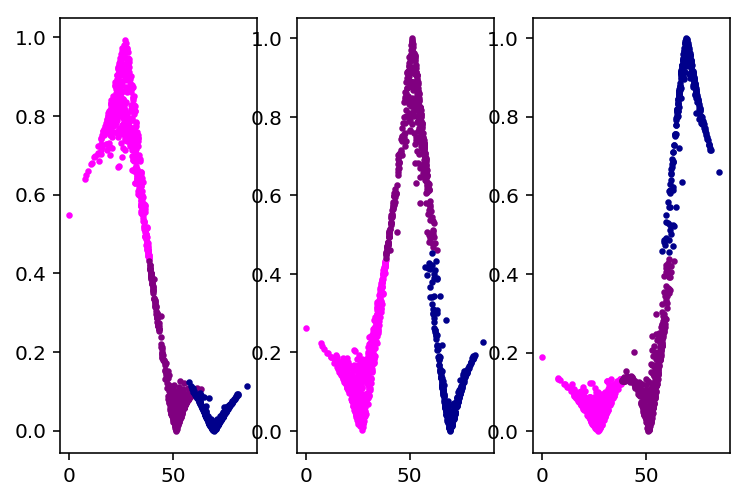

Dataset 2


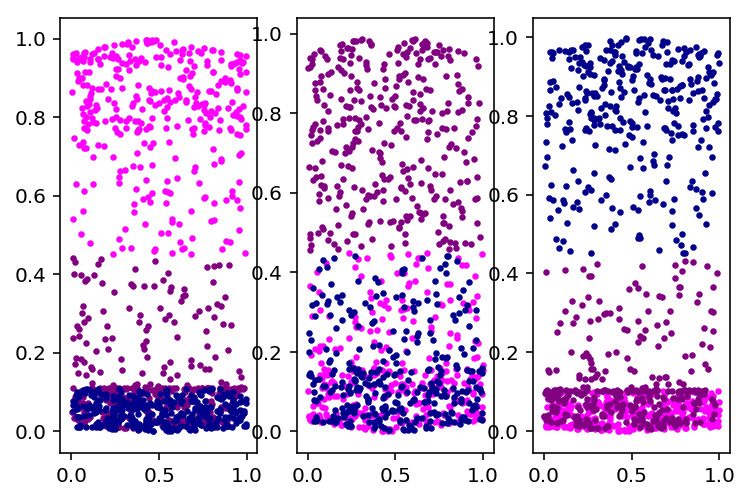

In [9]:
# Do not change
n_centers = 3
m = 2.5
error = 0.0005
max_iter = 500

# Scikit fuzzy c-means
centers1, u1, _, _, _, _, _ = fuzz.cluster.cmeans(
    np.vstack((xpts1, ypts1)), n_centers, m, error, max_iter, init=None)
centers2, u2, _, _, _, _, _ = fuzz.cluster.cmeans(
    np.vstack((xpts2, ypts2)), n_centers, m, error, max_iter, init=None)

print("Dataset 1")
plt.subplot(1, 3, 1)
plot_membership(ypts1, u1[0], centers1, u1)
plt.subplot(1, 3, 2)
plot_membership(ypts1, u1[1], centers1, u1)
plt.subplot(1, 3, 3)
plot_membership(ypts1, u1[2], centers1, u1)
plt.show()

print("Dataset 2")
plt.subplot(1, 3, 1)
plot_membership(ypts2, u2[0], centers2, u2)
plt.subplot(1, 3, 2)
plot_membership(ypts2, u2[1], centers2, u2)
plt.subplot(1, 3, 3)
plot_membership(ypts2, u2[2], centers2, u2)
plt.show()

### Question 3.2 (20 points)

Now we are going to estimate Gaussian membership functions for this data, one per cluster. 
1. Implement ```gaus()``` that returns the membership degree of datapoint x, given the mean and the standard deviation.
2. Implement ```plot_estimated_mf()``` that estimates a Gaussian membership function based on the data and returns the membership degree for the ypts we gave as input. We use ```scipy.optimize.curve_fit()``` to estimate the membership function.
3. Plot the estimated membership functions on top of the data. You can use ```skfuzzy```'s ```gaussmf``` function for this. (http://pythonhosted.org/scikit-fuzzy/api/skfuzzy.html#gaussmf). Code for this is already given. If you implemented 1 and 2 correctly, and did not change the parameters, you can simply run the code below to plot the data and the estimated membership functions.

Extra information on ```scipy.optimize.curve_fit()```: it uses non-linear least squares to fit a function (gaussian in this case) to the data. Initially we give it the function, the datapoints, the membership degrees, an initial estimation of the mean and variance, and it returns the optimal parameters for the gaussian fit (popt: [mean, variance]):
Syntax: ```popt, _ = curve_fit(function, ypts, u, p0=[mean, sigma])```

In [10]:
# Returns membership degree of datapoint x as
# fuzz.gaussmf() would
def gaus(x, mean, std):
    """Manual vs skfuzzy."""
    return exp(-0.5 * ((x - mean) / std) ** 2)

In [11]:
# Estimates gaussian membership function
def plot_estimated_mf(function, ypts, u, mean, std):
    """Plot the datapoints and the estimated membership degrees,
    as estimated with scipy's curve_fit."""

    # Fit to calculate mean and std
    popt, _ = curve_fit(function, ypts, u, p0=[mean, std])
    
    # Calculate actual membership degrees using
    # fitted parameters
    membership_degrees = function(ypts, *popt)

    # Plot original and estimated
    plt.scatter(ypts, u, color='red', s=5)
    plt.scatter(ypts, membership_degrees, s=5)
    
    return membership_degrees

Dataset 1


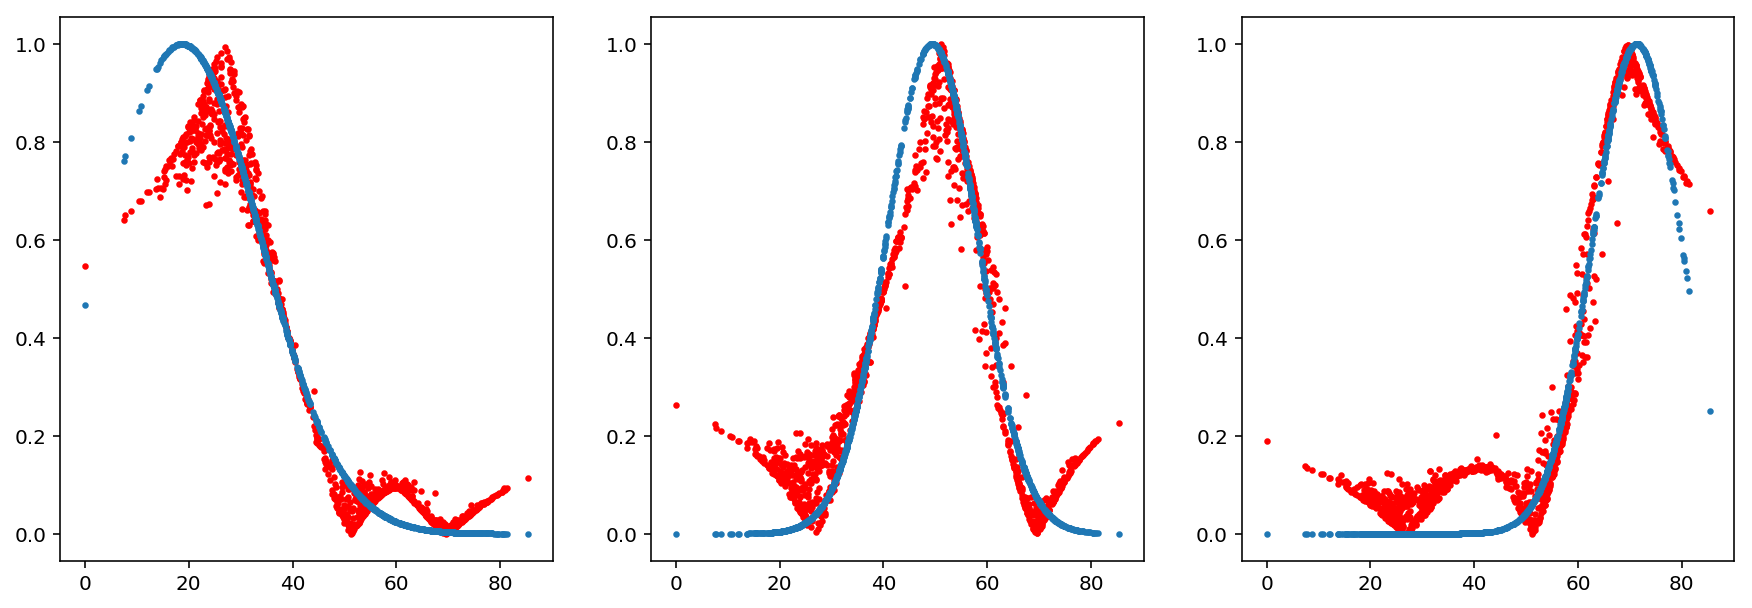

Dataset 2


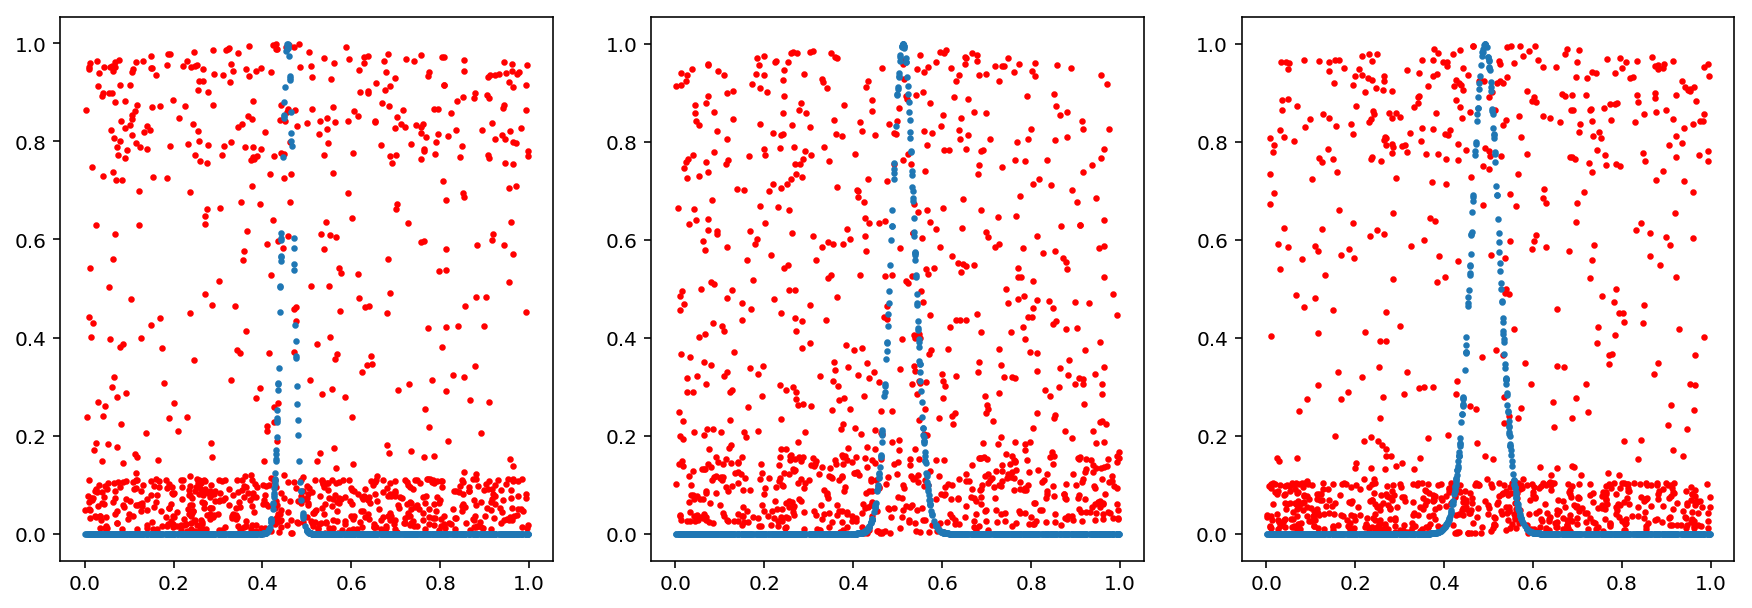

In [12]:
# Dataset 1, calculate initial means, and sigmas, and then fit membership functions
ax = plt.figure(figsize=(15, 5))    
print("Dataset 1")
means = [centers1[i][1]  for i in range(n_centers)] # get mean from cluster centers
sigmas = [np.sqrt(sum(u1[i]*(ypts1-means[i])**2) / len(ypts1)) for i in range(n_centers)] # estimate std

mfs_dataset1 = []
for i in range(3):
    plt.subplot(1, 3, i+1)
    mfs_dataset1.append(plot_estimated_mf(gaus, ypts1, u1[i], means[i], sigmas[i]))
plt.show()

# Dataset 2, calculate initial means, and sigmas, and then fit membership functions
ax = plt.figure(figsize=(15, 5))
print("Dataset 2")
means = [centers2[i][1]  for i in range(n_centers)]# get mean from cluster centers
sigmas = [sum(u2[i]*(ypts2-means[i])**2) / len(ypts2) for i in range(n_centers)] # estimate variance

mfs_dataset2 = []
for i in range(3):
    plt.subplot(1, 3, i+1)
    mfs_dataset2.append(plot_estimated_mf(gaus, ypts2, u2[i], means[i], sigmas[i]))
plt.show()

Now we can plot the membership functions together on the entire range of input 1 (0 to 10). Are they starting to look like 'regular' membership functions already?

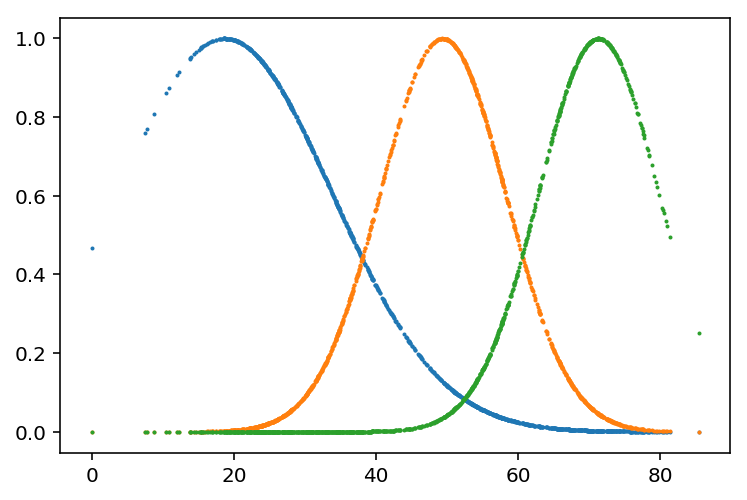

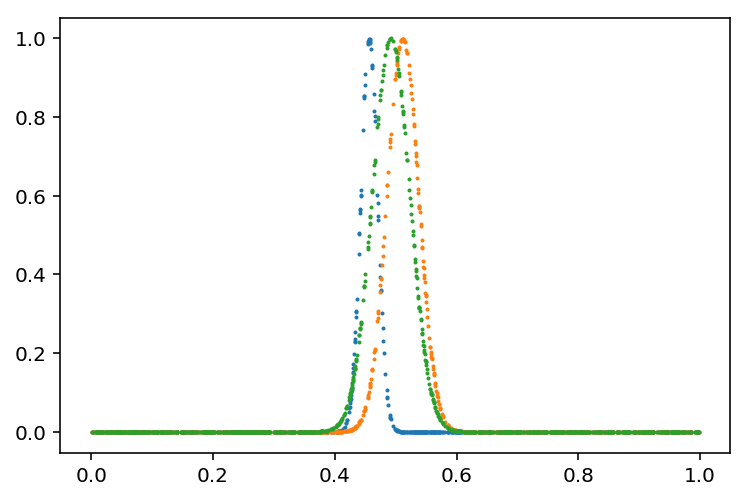

In [13]:
for i in range(3):
    plt.scatter(ypts1, mfs_dataset1[i], s=1)
plt.show()

for i in range(3):
    plt.scatter(ypts2, mfs_dataset2[i], s=1)
plt.show()

## 4. Evaluating (20 points total, BONUS)

### Question 4.1 (12 points)


Using your own implementation, write down the means and standard deviations for each of the Gaussian membership functions found for dataset 1 and dataset 2. Using the same assumption in Question 3, we have 3 MFs per dataset. 

> Dataset 1, membership function 1: mean 18.68057661, standard deviation 15.13172543

> Dataset 1, membership function 2: mean 49.36324924, standard deviation 8.832541460

> Dataset 1, membership function 3: mean 71.29346319, standard deviation 8.476929120

> Dataset 2, membership function 1: mean 0.45631150, standard deviation 0.02600023

> Dataset 2, membership function 2: mean 0.49210734, standard deviation 0.03083964

> Dataset 2, membership function 3: mean 0.51146811, standard deviation 0.01361601

### Question 4.2 (4 points)

Discuss whether the membership functions found or estimated are suitable for a Fuzzy Logic application:

> Dataset 1: Yes, the functions cover the entire domain and the means are spread out well enough.

> Dataset 2: No, the overlap is gigantic, while the functions don't cover the entire domain.

### Question 4.3 (4 points)

After the thorough data inspection we did, can you estimate whether the data was generated according to Gaussian distributions?

> Dataset 1: Yes, this dataset could have been generated from Gaussian distributions because the datapoints are located around the normal distribution, which could be simultated by adding an error value.

> Dataset 2: No, because the datapoints are not distributed following a pattern.